In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import shutil
from matplotlib import pyplot as plt

In [329]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [330]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [331]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [332]:
#Make the directories
try:
    os.makedirs(POS_PATH)
    os.makedirs(NEG_PATH)
    os.makedirs(ANC_PATH)
except Exception:
    pass

In [ ]:
# !tar -xf lfw.tgz

In [ ]:
# # Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [335]:
# Import uuid library to generate unique image names
import uuid

In [336]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))


'data/anchor/f749f462-a65d-11ee-9d7b-86d3b33983d7.jpg'

In [334]:

cap = cv2.VideoCapture(1)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[200:250+200, 525:250+525, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
     
    
    cv2.imshow('Image Collection', frame)
    cv2.startWindowThread()

    if cv2.waitKey(1) & 0xFF in (ord('q'), ord('Q')):
        break

cap.release()
for i in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)


In [ ]:
# plt.imshow(frame[300:250+300, 500:250+500, :])

In [337]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(50)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(50)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(50)

In [338]:
dir_test = anchor.as_numpy_iterator() 

In [342]:
dir_test.next()

b'data/anchor/3100e1b2-a65d-11ee-9d7b-86d3b33983d7.jpg'

In [343]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [345]:
img = preprocess("data/anchor/3100e1b2-a65d-11ee-9d7b-86d3b33983d7.jpg")

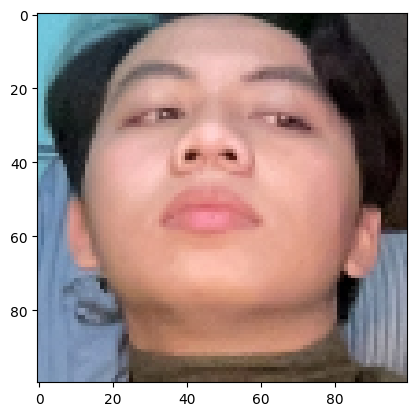

In [346]:
plt.imshow(img)

In [347]:
img.numpy().max()

1.0

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [348]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [349]:
iterator_labs = class_labels.as_numpy_iterator()

In [350]:
iterator_labs.next()

0.0

In [351]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)

In [352]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [353]:
samples = data.as_numpy_iterator()

In [354]:
example = samples.next()  

In [355]:
example

(b'data/anchor/32ded048-a65d-11ee-9d7b-86d3b33983d7.jpg',
 b'data/positive/3c829576-a65d-11ee-9d7b-86d3b33983d7.jpg',
 1.0)

In [356]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [357]:
res = preprocess_twin(*example)

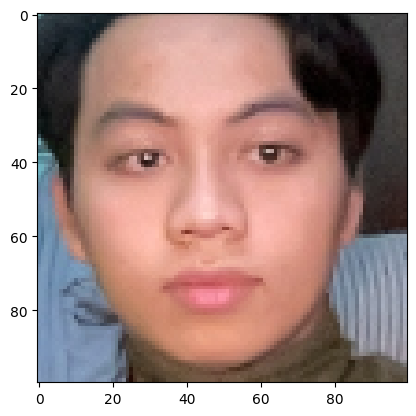

In [363]:
plt.imshow(res[0])

In [364]:
res[2]

1.0

In [365]:
# Build data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [366]:
# Training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


In [367]:
train_samples = train_data.as_numpy_iterator()


In [376]:
train_sample  = train_samples.next()

In [377]:
len(train_sample[0])

16

In [378]:
samples = data.as_numpy_iterator()

In [379]:
len(samples.next())

3

In [380]:
samp = samples.next()

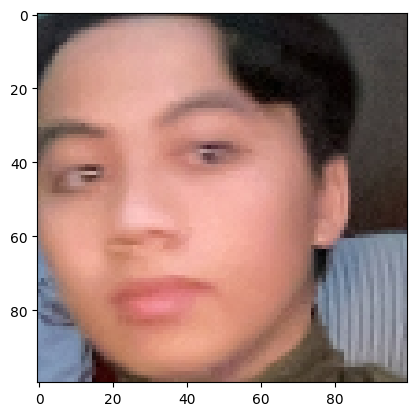

In [381]:
plt.imshow(samp[0])

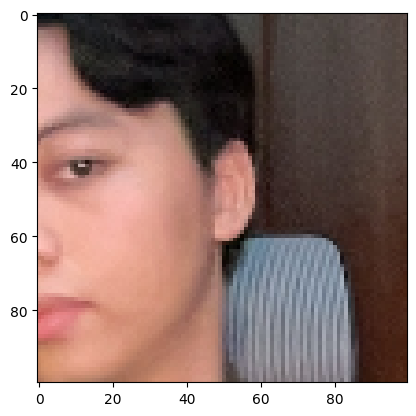

In [382]:
plt.imshow(samp[1])

In [383]:
samp[2]

1.0

In [385]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### MODEL ENGINEERING

In [401]:
inp = Input(shape=(100, 100, 3), name = 'input_image')
### We can change to 105x105 to match the paper

In [402]:
c1 = Conv2D(64, (10, 10), activation='relu')(inp)


In [403]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_3')>

In [404]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [407]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

In [410]:
# Third block
c3 = Conv2D(128, (4,4), activation ='relu')(m2)
m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

# Last block
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation="sigmoid")(f1)

In [417]:
mod = Model(inputs=[inp], outputs=[d1], name = 'embedding')

In [418]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 128)       26

In [422]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name = 'input_image')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Third block
    c3 = Conv2D(128, (4,4), activation ='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Last block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    

    return Model(inputs=[inp], outputs=[d1], name = 'embedding')

In [429]:
embedding = make_embedding()

In [430]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 17, 17, 128)       26

# Build Distance layer

In [425]:
# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [426]:
l1 = L1Dist()

# Make Siamese Model

In [433]:
input_image = Input(name = 'input_img', shape=(100, 100,3 ))
validation_image = Input(name = 'validation_img', shape=(100, 100,3 ))


In [434]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [435]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [436]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [437]:
siamese_layer = L1Dist()

In [466]:
distances = siamese_layer(inp_embedding, val_embedding)

In [467]:
classifier = Dense(1, activation='sigmoid')(distances)


In [470]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [471]:
siamese_net = Model(inputs=[input_image, validation_image], outputs= classifier, name = "SiameseNetwork")
siamese_net.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [440]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name = 'input_img', shape=(100, 100,3 ))
    
    # Validation image in the network
    validation_image = Input(name = 'validation_img', shape=(100, 100, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation = "sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs= classifier, name = "SiameseNetwork")
    

In [441]:
siamese_model = make_siamese_model()

In [442]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

### Training

# Setup loss and optimizer

In [472]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [473]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# Establishing Checkpoints

In [474]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

# Build train step function

In [475]:
test_batch = train_data.as_numpy_iterator()

In [476]:
batch1 = test_batch.next()

In [477]:
X = batch1[:2]

In [478]:
y = batch1[2]

In [479]:
y

array([0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

In [480]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

# Build training loop

In [481]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [482]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# train model

In [483]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
